# Plot WML Measurements

Download and rename files with identical names:

In [1]:
%%bash
mkdir -p res_controls
i=1
for file_id in $(dx find data --path ms_wml_quantification/results/output/controls/ --name lesion_volumes.csv --brief); do
    dx download -f "$file_id" -o res_controls/lesion_volumes-${i}.csv
    i=$((i+1))
done
mkdir -p res_fabry
i=1
for file_id in $(dx find data --path ms_wml_quantification/results/output/fabry/ --name lesion_volumes.csv --brief); do
    dx download -f "$file_id" -o res_fabry/lesion_volumes-${i}.csv
    i=$((i+1))
done

In [1]:
!dx download ms_wml/wml_functions.py

In [2]:
from glob import glob
from math import sqrt
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from statistics import mean, stdev

/tmp/ipykernel_1807/3917381452.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# combine multiple results files

control_path = '/opt/notebooks/res_controls/'
fabry_path = '/opt/notebooks/res_fabry/'

controls = []
for file in glob(control_path+'lesion_volumes-*.csv'):
    df = pd.read_csv(file)
    df = df[df.columns.drop(list(df.filter(regex='Unnamed')))]
    controls.append(df)
control_df = pd.concat(controls).reset_index(drop=True)
print(len(control_df['names'].unique()), 'controls found.')

fabrys = []
for file in glob(fabry_path+'lesion_volumes-*.csv'):
    df = pd.read_csv(file)
    df = df[df.columns.drop(list(df.filter(regex='Unnamed')))]
    fabrys.append(df)
fabry_df = pd.concat(fabrys).reset_index(drop=True)
print(len(fabry_df['names'].unique()), 'Fabrys found')

45 controls found.
15 Fabrys found


In [4]:
# save combined dataframes
control_df.to_csv(control_path+'lesion_volumes_all.csv', index=False)
fabry_df.to_csv(fabry_path+'lesion_volumes_all.csv', index=False)

In [25]:
control_df.head()

,names,lesion volume [ml],lesion volume per brain volume,age
0,1001332_20253_2_0,3.512000,0.002513,68
1,1053913_20253_2_0,10.696024,0.008946,72
2,1008017_20253_2_0,2.158993,0.001626,68
3,1057528_20253_2_0,1.531000,0.001165,72
4,1033424_20253_2_0,1.634000,0.001109,65


Cohen's d: 	 	absolute lesion volume: -0.05636776695120232,	relative lesion volume: -0.05924788706609062
Mean difference: 	absolute lesion volume: -0.239242309496138 ml,	relative lesion volume: -0.0001858194509180601


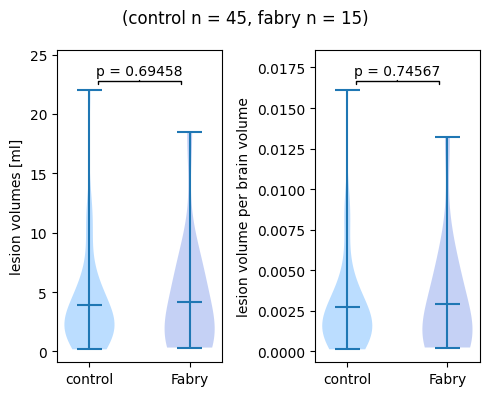

In [20]:
# plot measurements (violin)

plt.subplots(1, 2, figsize=[5, 4])
plt.suptitle('(control n = '+str(len(control_df['names'].tolist()))+', fabry n = '+str(len(fabry_df['names'].tolist()))+')')

plt.subplot(1, 2, 1)
viols = plt.violinplot([control_df['lesion volume [ml]'].tolist(), fabry_df['lesion volume [ml]'].tolist()], positions=[0, 1], showmeans=True, showextrema=True)
for pc, color in zip(viols['bodies'], ['dodgerblue', 'royalblue']):
    pc.set_facecolor(color)

# test significance
_, p = scipy.stats.mannwhitneyu(control_df['lesion volume [ml]'].tolist(), fabry_df['lesion volume [ml]'].tolist())
plt.annotate('p = '+str(np.round(p, 5)),
             xytext=(0.5, 0.91),
             textcoords=('data', 'axes fraction'), 
             xy=(0.5, 0.9), 
             xycoords=('data', 'axes fraction'), 
             ha='center', va='bottom', 
             arrowprops=dict(arrowstyle='-[, widthB=3'))
_, t = plt.ylim()
plt.ylim(top=t*1.1)
    
plt.ylabel('lesion volumes [ml]')
plt.xticks([0, 1], ['control', 'Fabry'])

plt.subplot(1, 2, 2)
viols = plt.violinplot([control_df['lesion volume per brain volume'].tolist(), fabry_df['lesion volume per brain volume'].tolist()], positions=[0, 1], showmeans=True, showextrema=True)
for pc, color in zip(viols['bodies'], ['dodgerblue', 'royalblue']):
    pc.set_facecolor(color)
    
# test significance
_, p = scipy.stats.mannwhitneyu(control_df['lesion volume per brain volume'].tolist(), fabry_df['lesion volume per brain volume'].tolist())
plt.annotate('p = '+str(np.round(p, 5)),
             xytext=(0.5, 0.91),
             textcoords=('data', 'axes fraction'), 
             xy=(0.5, 0.9), 
             xycoords=('data', 'axes fraction'), 
             ha='center', va='bottom', 
             arrowprops=dict(arrowstyle='-[, widthB=3'))
_, t = plt.ylim()
plt.ylim(top=t*1.1)

plt.ylabel('lesion volume per brain volume')
plt.xticks([0, 1], ['control', 'Fabry'])

plt.tight_layout()

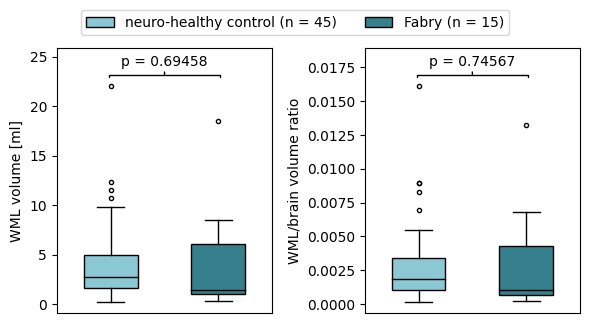

In [6]:
# plot measurements (box)

colors = [mpl.colors.to_rgb(c) for c in ["#6fb9ca", "#035f71"]]  # light and dark teal
alpha = 0.8
flierprops = dict(marker='.', markersize=6)

fig, _ = plt.subplots(1, 2, figsize=(6, 3))

# plot WML volume
plt.subplot(1, 2, 1)
boxes = plt.boxplot(
    [control_df['lesion volume [ml]'].tolist(), fabry_df['lesion volume [ml]'].tolist()], positions=[0, 1], 
    widths=0.5, flierprops=flierprops, patch_artist=True)
for patch, color in zip(boxes['boxes'], colors):
    patch.set_facecolor(color+(alpha,))
for patch in boxes['medians']:
    patch.set_color('black')
plt.xticks([])
plt.ylabel('WML volume [ml]')

plt.annotate('p = '+str(np.round(scipy.stats.mannwhitneyu(control_df['lesion volume [ml]'].tolist(), fabry_df['lesion volume [ml]'].tolist())[1], 5)),
             xytext=(0.5, 0.92),
             textcoords=('data', 'axes fraction'), 
             xy=(0.5, 0.9), 
             xycoords=('data', 'axes fraction'), 
             ha='center', va='bottom', 
             arrowprops=dict(arrowstyle='-[, widthB=4'))
_, t = plt.ylim();
plt.ylim(top=t*1.12);

# plot WML/brain volume ratio
plt.subplot(1, 2, 2)
boxes = plt.boxplot(
    [control_df['lesion volume per brain volume'].tolist(), fabry_df['lesion volume per brain volume'].tolist()], 
    positions=[0, 1], widths=0.5, flierprops=flierprops, patch_artist=True)
for patch, color in zip(boxes['boxes'], colors):
    patch.set_facecolor(color+(alpha,))
for patch in boxes['medians']:
    patch.set_color('black')
plt.xticks([])
plt.ylabel('WML/brain volume ratio')

plt.annotate('p = '+str(np.round(scipy.stats.mannwhitneyu(control_df['lesion volume per brain volume'].tolist(), fabry_df['lesion volume per brain volume'].tolist())[1], 5)),
             xytext=(0.5, 0.92),
             textcoords=('data', 'axes fraction'), 
             xy=(0.5, 0.9), 
             xycoords=('data', 'axes fraction'), 
             ha='center', va='bottom', 
             arrowprops=dict(arrowstyle='-[, widthB=4'))
_, t = plt.ylim();
plt.ylim(top=t*1.12);

patches = [mpl.patches.Patch(facecolor=c+(alpha,), edgecolor='black', label=l) for c, l in zip(colors, ['neuro-healthy control (n = 45)', 'Fabry (n = 15)'])]
fig.legend(handles=patches, loc='upper center', bbox_to_anchor=(0.5, 1.10), ncols=2)

plt.tight_layout()

In [10]:
# calculate statistics

c = control_df['lesion volume [ml]'].tolist()
f = fabry_df['lesion volume [ml]'].tolist()
stdev_pool = sqrt( ((len(c)-1)*stdev(c)**2 + (len(f)-1)*stdev(f)**2) / (len(c)+len(f)-2))
da = abs((mean(c) - mean(f)) / (stdev_pool))  # cohen's d
ma = abs((mean(c) - mean(f)))  # mean difference

c = control_df['lesion volume per brain volume'].tolist()
f = fabry_df['lesion volume per brain volume'].tolist()
stdev_pool = sqrt( ((len(c)-1)*stdev(c)**2 + (len(f)-1)*stdev(f)**2) / (len(c)+len(f)-2))
dr = abs((mean(c) - mean(f)) / (stdev_pool))  # cohen's d
mr = abs((mean(c) - mean(f)))  # mean difference

df = pd.DataFrame([[da, ma], [dr, mr]], columns=['absolute WML volume', 'WML/brain volume ratio'], index=['Cohen\'s d', 'mean difference'])
df.to_csv('/opt/notebooks/wml_stats.csv')
df

,absolute WML volume,WML/brain volume ratio
Cohen's d,0.056368,0.239242
mean difference,0.059248,0.000186


2246683
12
Fabry mean age: 64.8
Control mean age: 64.04444444444445


/tmp/ipykernel_737/2257051499.py:21: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  c_measurements['age'][11] = 62  # for some reason, this isn't found automatically
/tmp/ipykernel_737/2257051499.py:21: SettingWithCopyWarning: 
A value is try

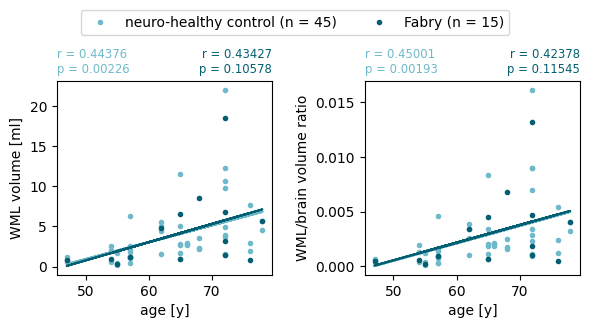

In [23]:
# correlate with age

# get measurements
c_measurements = control_df
f_measurements = fabry_df

c_table = pd.concat([pd.read_csv(file) for file in ['/mnt/project/ms_wml/cohorts/control_table-2.csv', '/mnt/project/ms_wml/cohorts/control_table.csv']])
f_table = pd.read_csv('/mnt/project/ms_wml/cohorts/fabry_table-2.csv')

for m, t in zip([c_measurements, f_measurements], [c_table, f_table]):
    m['age'] = [0]*len(m['names'])
    for i, this_id in enumerate(m['names']):
        this_id = int(this_id.split('_')[0])
        try:
            age = t.loc[t['Participant ID'] == this_id, 'Age when attended assessment centre | Instance 2'].values[0]
        except:
            print(this_id)
            print(i)
        m.loc[i, 'age'] = age

c_measurements['age'][11] = 62  # for some reason, this isn't found automatically

fig, _ = plt.subplots(1, 2, figsize=(6, 3))

def fit(X, Y, control=False, label=False):

    xbar = sum(X)/len(X)
    ybar = sum(Y)/len(Y)
    n = len(X) # or len(Y)

    numer = sum([xi*yi for xi,yi in zip(X, Y)]) - n * xbar * ybar
    denum = sum([xi**2 for xi in X]) - n * xbar**2

    b = numer / denum
    a = ybar - b * xbar

    yfit = [a + b * xi for xi in X]
    
    if control:
        color=colors[0]
        # alpha=0.5
        alpha=1.0
        loc='left'
    else:
        color=colors[1]
        alpha=1.0
        loc='right'
    if label == False:
        plt.plot(X, Y, color=color, linestyle='', marker='.', alpha=alpha)
    else:
        plt.plot(X, Y, color=color, linestyle='', marker='.', alpha=alpha, label=label)
    plt.plot(X, yfit, color=color, alpha=alpha)
    r, p = scipy.stats.pearsonr(X, Y)
    plt.title('r = '+str(np.round(r, 5))+'\np = '+str(np.round(p, 5)), loc=loc, color=color, fontsize='small')

def plot_fit(c, f, key, ylabel, label=False):
    if label == False:
        label = [False, False]
    
    if type(key) is str or (type(key) is list and len(key) == 1):
        fit(c['age'], c[key], control=True, label=label[0])
        fit(f['age'], f[key], label=label[1])
    else:
        fit(c['age']*len(key), [i for k in key for i in c[k]], control=True, label=label[0])
        fit(f['age']*len(key), [i for k in key for i in f[k]], label=label[1])
    plt.xlabel('age [y]')
    plt.ylabel(ylabel)

keys = ['lesion volume [ml]', 'lesion volume per brain volume']
labels = ['WML volume [ml]', 'WML/brain volume ratio']

plt.subplot(1, 2, 1)
plot_fit(c_measurements, f_measurements, keys[0], labels[0], label=['neuro-healthy control (n = 45)', 'Fabry (n = 15)'])

plt.subplot(1, 2, 2)
plot_fit(c_measurements, f_measurements, keys[1], labels[1])
    
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2)
plt.tight_layout()

# get mean age
print('Fabry mean age:', np.mean(f_measurements['age']))
print('Control mean age:', np.mean(c_measurements['age']))

In [77]:
c_measurements.to_csv('/opt/notebooks/control_lesion_volumes.csv', index=False)
f_measurements.to_csv('/opt/notebooks/fabry_lesion_volumes.csv', index=False)